We train RFs on hand-labeled Planet data and apply them on the broader planet chip to generate classifications. Compare these outputs with the overlapping DSWx-HLS tile

Generate statistics/confusion matrix for each comparison

We will demonstrate this for one Planet acquisition here, and the expand it to other validation sites in subsequent notebooks

In [1]:
# gis imports
import rasterio
from rasterio.merge import merge
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.windows import from_bounds
from shapely.geometry import box
from rasterio.mask import mask
import geopandas as gpd
from tools import get_geopandas_features_from_array, resample_labels_into_percentage, reclassify_percentage_array_for_dswx
from dem_stitcher.rio_window import read_raster_from_window
from dem_stitcher.rio_tools import reproject_arr_to_match_profile, update_profile_resolution

# matplotlib imports
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import PercentFormatter

# sklearn imports
import sklearn
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import sklearn.metrics
import numpy as np

# misc imports
import pandas as pd
from pathlib import Path
from itertools import starmap
from pandas import json_normalize
import warnings
from tqdm import tqdm

In [2]:
EQUAL_SAMPLING = True  # if false currently uses validation labels to determine size of each class sample
TOTAL_PIXELS_PER_SAMPLE = 1_000
NUMBER_OF_RANDOM_SAMPLES = 100  # aka number of trials
SAMPLE_FROM_DSWX = False # either sample from validation data or dswx (note this does not impact class sizes)
USE_ENTIRE_IMAGE = False # if True, random sampling and trials is moot and just directly samples from entire image
WITH_REPLACEMENT = False # whether to replace samples - will ensure equality if present, untested
CONFIDENCE_CLASSES = []#[0, 1, 2, 3] # Confidence classes to be included (if empty include ALL)
DOWNSAMPLE_BOTH_DS_TO_3_HA = False # downsample both datasets to 3 ha
USE_AEROSOL_MASK = False
NUMBER_OF_RANDOM_SAMPLES = 100

For any given validation dataset, we will consider the source Planet image and the overlapping DSWx tile to calculate statistics.

In [3]:
df = pd.read_csv('../data/new_validation_table.csv')
df.head()

,dswx_files,fmask_files,conf_files,rf_classification_files
0,../data/20210903_150800_60_2458/OPERA_L3_DSWx-...,../data/20210903_150800_60_2458/HLS.L30.T18UXG...,../data/20210903_150800_60_2458/OPERA_L3_DSWx-...,../data/planet_images_cropped/20210903_150800_...
1,../data/20210903_152641_60_105c/OPERA_L3_DSWx-...,../data/20210903_152641_60_105c/HLS.S30.T19UDA...,../data/20210903_152641_60_105c/OPERA_L3_DSWx-...,../data/planet_images_cropped/20210903_152641_...
2,../data/20210904_093422_44_1065/OPERA_L3_DSWx-...,../data/20210904_093422_44_1065/HLS.S30.T33JYG...,../data/20210904_093422_44_1065/OPERA_L3_DSWx-...,../data/planet_images_cropped/20210904_093422_...
3,../data/20210906_101112_28_225a/OPERA_L3_DSWx-...,../data/20210906_101112_28_225a/HLS.S30.T30TYN...,../data/20210906_101112_28_225a/OPERA_L3_DSWx-...,../data/planet_images_cropped/20210906_101112_...
4,../data/20210909_000649_94_222b/OPERA_L3_DSWx-...,../data/20210909_000649_94_222b/HLS.L30.T54JTM...,../data/20210909_000649_94_222b/OPERA_L3_DSWx-...,../data/planet_images_cropped/20210909_000649_...


In [4]:
row = df.iloc[0]
dswx_file = row['dswx_files'].split()[0]
fmask_file =row['fmask_files'].split()[0]
conf_file = row['conf_files'].split()[0]
classification_file = row['rf_classification_files']
print(dswx_file, fmask_file, conf_file, classification_file)

../data/20210903_150800_60_2458/OPERA_L3_DSWx-HLS_T18UXG_20210902T154154Z_20230323T180150Z_L8_30_v1.0_B01_WTR.tif ../data/20210903_150800_60_2458/HLS.L30.T18UXG.2021245T154154.v2.0.Fmask.tif ../data/20210903_150800_60_2458/OPERA_L3_DSWx-HLS_T18UXG_20210902T154154Z_20230323T180150Z_L8_30_v1.0_B03_CONF.tif ../data/planet_images_cropped/20210903_150800_60_2458/full_img_rf_classification_classification_20210903_150800_60_2458_formatted.tif


We need to resample RF outputs to the DSWx CRS. We need to account for Fmask and no data, and also mask out water bodies that are smaller than 3 ha

In [5]:
tmp_folder = Path(dswx_file).parent / "tmp"
tmp_folder.mkdir(exist_ok=True)

In [6]:
def return_intersection_bounds(bounds_list):
    """
    Given a list of bounds in the format [(xmin, ymin, xmax, ymax) .. ], return the bounds that describe the smallest overlapping area
    """
    stacked_bounds = np.stack(bounds_list, axis=0)
    bounds = [max(stacked_bounds[:, 0]), max(stacked_bounds[:, 1]), min(stacked_bounds[:, 2]), min(stacked_bounds[:, 3])]

    if (bounds[0] > bounds[2]) or (bounds[1] > bounds[3]):
        warnings.warn("Valid overlapping area not found")
        return 4*[np.nan]
    else:
        return bounds

In [7]:
with rasterio.open(dswx_file) as ds:
    dswx_crs = ds.crs
    colormap = ds.colormap(1)
    dswx_bounds = ds.bounds

cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
df_dswx_bounds = gpd.GeoDataFrame(geometry = [box(*dswx_bounds).buffer(60)], crs=dswx_crs)

with rasterio.open(classification_file) as ds:
    val_bounds = ds.bounds
    val_crs = ds.crs
    p_val = ds.profile

df_val_bounds = gpd.GeoDataFrame(geometry = [box(*val_bounds).buffer(60)], crs=val_crs)

In [8]:
with rasterio.open(fmask_file) as ds:
    X_fmask = ds.read(1)
    p_fmask = ds.profile

with rasterio.open(conf_file) as ds:
    X_conf = ds.read(1)
    p_conf = ds.profile

# Generate masks to block out regions over which we do not compare DSWx/RF outputs
# 224 is the ocean mask class
X_224 = (X_fmask == 224)

# 160 is ??
X_160 = (X_fmask == 160)

X_aerosol = X_224 | X_160

In [9]:
# conf_dswx_c_original, _ = read_raster_from_window(conf_files[0], 
#                                                   list(df_val_bounds.total_bounds), 
#                                                   df_val_bounds.crs)
# conf_dswx_c, _ = reproject_arr_to_match_profile(conf_dswx_c_original, 
#                                                 p_dswx_conf_original, 
#                                                 p_per_int)
# conf_dswx_c = conf_dswx_c[0, ...]

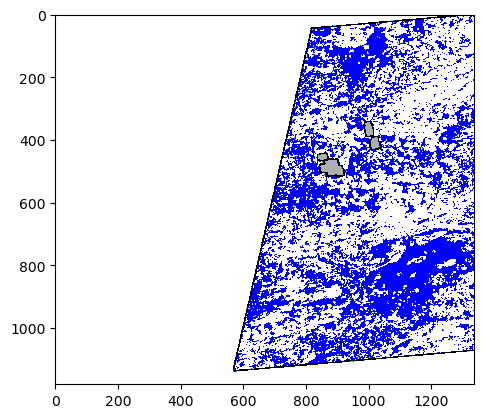

In [10]:
intersection_shape = gpd.GeoDataFrame(geometry = [df_val_bounds.to_crs(dswx_crs).iloc[0].geometry.intersection(df_dswx_bounds.iloc[0].geometry)], crs=dswx_crs)
with rasterio.open(dswx_file) as ds:
    X_dswx, X_dswx_out_transform = mask(ds, intersection_shape.iloc[0], crop=True)
    X_dswx_out_meta = ds.meta
plt.imshow(X_dswx[0], cmap=cmap)

X_dswx_out_meta.update({"driver": "GTiff",
                 "height": X_dswx.shape[1],
                 "width": X_dswx.shape[2],
                 "transform": X_dswx_out_transform})

# with rasterio.open(tmp_folder / "dswx_cropped.tif", "w", **X_dswx_out_meta) as dst:
#     dst.write(X_dswx)

# X_dswx = np.squeeze(X_dswx)

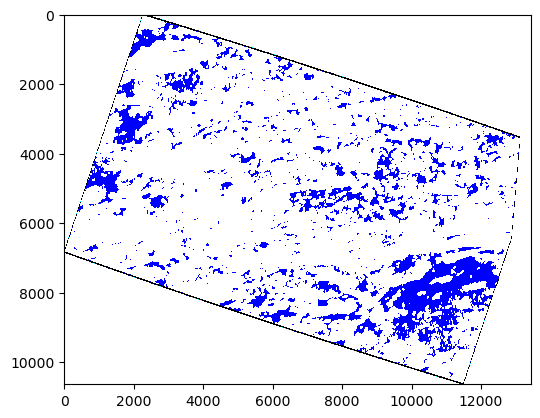

In [11]:
intersection_shape = gpd.GeoDataFrame(geometry = [df_dswx_bounds.to_crs(val_crs).iloc[0].geometry.intersection(df_val_bounds.iloc[0].geometry)], crs=val_crs)
with rasterio.open(classification_file) as ds:
    X_val, X_val_out_transform = mask(ds, intersection_shape.iloc[0], crop=True)
    X_val_out_meta = ds.meta
plt.imshow(X_val[0], cmap=cmap)

X_val_out_meta.update({"driver": "GTiff",
                 "height": X_val.shape[1],
                 "width": X_val.shape[2],
                 "transform": X_val_out_transform})

# with rasterio.open(tmp_folder / "val_cropped.tif", "w", **X_val_out_meta) as dst:
#     dst.write(X_val)

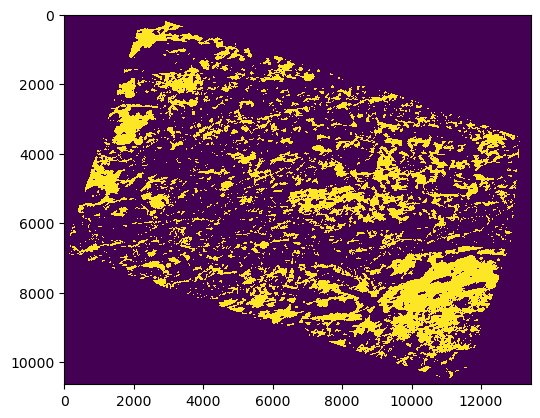

In [12]:
X_val = np.squeeze(X_val)
X_val_water_only = (X_val == 1).astype(int)
plt.imshow(X_val_water_only, interpolation='none')

984.0


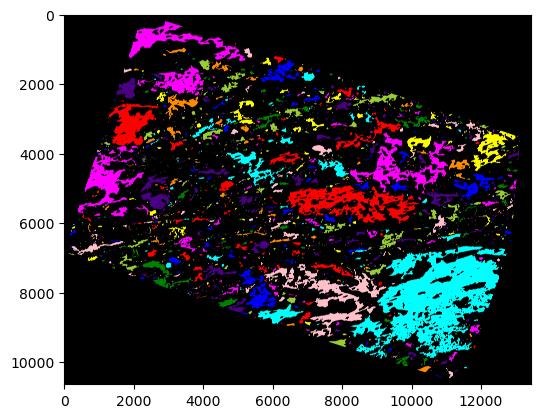

In [13]:
water_labels = label(X_val_water_only, connectivity=2)
water_labels_rbg = label2rgb(water_labels)
plt.imshow(water_labels_rbg)

props = regionprops(water_labels)

if props:
    print(props[0].area)

In [14]:
N = min(len(props), 4)
for k in range(N):
    print('key/size label: ', k)
    print('One way:', (water_labels == (k+1)).sum())
    print('region props: ', props[k].area)

key/size label:  0
One way: 984
region props:  984.0
key/size label:  1
One way: 8
region props:  8.0
key/size label:  2
One way: 8
region props:  8.0
key/size label:  3
One way: 909610
region props:  909610.0


In [15]:
labels_to_exclude = [(k+1) for (k, prop) in enumerate(props) if prop.area <= 3333]
size_mask = np.isin(water_labels, labels_to_exclude)

Text(0.5, 1.0, 'Water bodies to be excluded')

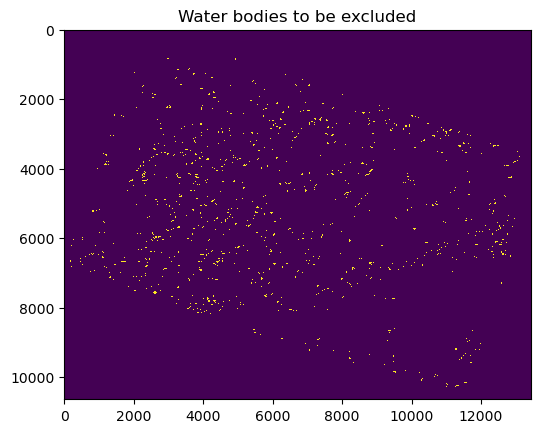

In [16]:
plt.imshow(size_mask, interpolation='none')
plt.title('Water bodies to be excluded')

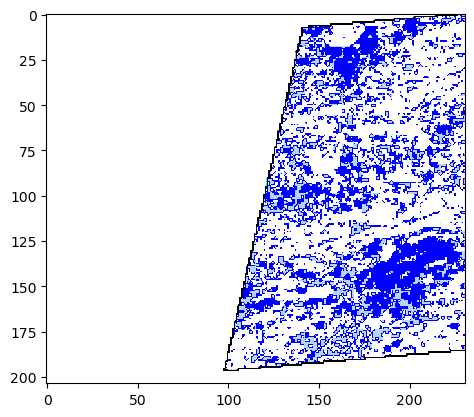

In [17]:
p_dswx_c_3ha_temp = update_profile_resolution(X_dswx_out_meta, 100 * np.sqrt(3))
p_dswx_c_3ha_temp['dtype'] = 'float32'
X_dswx_psw_percentage, p_dswx_c_3ha = resample_labels_into_percentage(X_dswx, X_dswx_out_meta, p_dswx_c_3ha_temp, 2)
X_dswx_psw_percentage *= .75
X_dswx_osw_percentage, _ = resample_labels_into_percentage(X_dswx, X_dswx_out_meta, p_dswx_c_3ha, 1)
X_dswx_c_3ha_percentage = X_dswx_psw_percentage + X_dswx_osw_percentage
X_dswx_c_3ha_percentage = np.clip(X_dswx_c_3ha_percentage, 0, 1)

X_dswx_c = reclassify_percentage_array_for_dswx(X_dswx_c_3ha_percentage)
p_dswx_c = p_dswx_c_3ha.copy()
p_dswx_c['dtype'] = np.uint8
p_dswx_c['nodata'] = 255

plt.imshow(X_dswx_c, cmap=cmap)

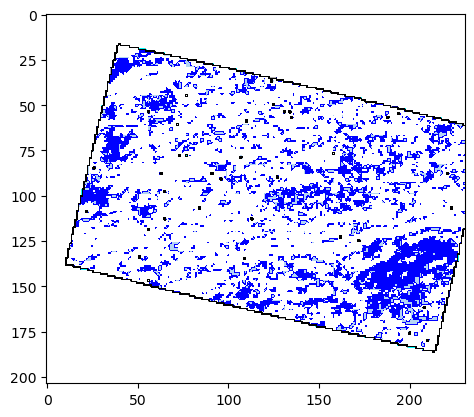

In [18]:
p_dswx_c_float = p_dswx_c.copy()
p_dswx_c_float['dtype'] = 'float32'

X_val_temp = X_val.astype('float32')
X_val_temp[(X_val == 10) | (X_val == 255) | size_mask] = np.nan
p_val_temp = p_val.copy()
p_val_temp['nodata'] = np.nan

X_val_per_w, p_per_int = resample_labels_into_percentage(X_val_temp, p_val_temp, p_dswx_c_float, 1)
X_val_r = reclassify_percentage_array_for_dswx(X_val_per_w)
plt.imshow(X_val_r, cmap=cmap)

In [19]:
# X_val_r_osw_psw = (X_val_r == 1) | (X_val_r == 2)
# water_labels_30m = label(X_val_r_osw_psw, connectivity=1, background=0)
# props = regionprops(water_labels_30m)

# labels_to_exclude_30m = [(k+1) for (k, prop) in enumerate(props) if prop.area <= 34]
# size_mask_30m = np.isin(water_labels_30m, labels_to_exclude_30m)
# plt.imshow(size_mask_30m, vmin=0, vmax=1)

Text(0.5, 1.0, 'Regions that will be masked out')

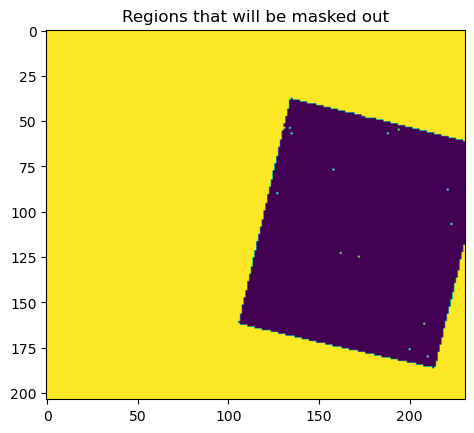

In [20]:
shared_mask = (X_val_r == 255) | ~(np.isin(X_dswx_c, [0, 1, 2])) # | size_mask_30m
plt.imshow(shared_mask)
plt.title("Regions that will be masked out")

In [21]:
# if CONFIDENCE_CLASSES:
#     # want to exclude everything not in desired confidence classes
#     confidence_mask = ~np.isin(conf_dswx_c, CONFIDENCE_CLASSES)
#     shared_mask = (shared_mask | confidence_mask)

# if USE_AEROSOL_MASK:
#     shared_mask = (shared_mask | X_aerosol_c)

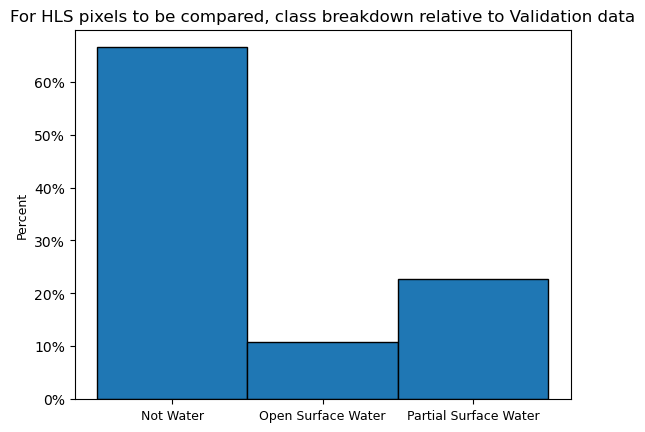

In [22]:
percents, _, _ = plt.hist(X_val_r[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to Validation data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

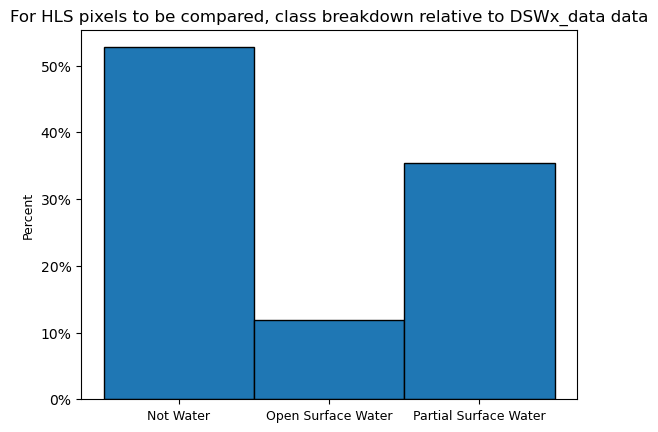

In [23]:
percents_dswx, _, _ = plt.hist(X_dswx_c[~shared_mask], bins=3, range=(0, 3), density=True, edgecolor='black')
plt.xticks(np.arange(0, 3)+.5, ['Not Water', 'Open Surface Water', 'Partial Surface Water'],fontsize=9)
plt.ylabel('Percent',fontsize=9)
plt.title('For HLS pixels to be compared, class breakdown relative to DSWx_data data');
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

In [24]:
sample_size_per_label = [int(np.ceil(percents[label] * TOTAL_PIXELS_PER_SAMPLE)) for label in [0, 1, 2]]
if EQUAL_SAMPLING:
    present_classes = (percents > 0).sum()
    #always multiply by 3 because we have 3 labels
    # sample sizes are modified depending on availability (see cell below)
    sample_size_per_label = [int(np.ceil(TOTAL_PIXELS_PER_SAMPLE / present_classes))] * 3
    
sample_size_per_label

[334, 334, 334]

In [25]:
validation_hls_pixels = X_val_r[~shared_mask]
dswx_hls_pixels = X_dswx_c[~shared_mask]

sample_pixels = dswx_hls_pixels if SAMPLE_FROM_DSWX else validation_hls_pixels

sample_str = 'dswx' if SAMPLE_FROM_DSWX else 'the validation dataset'
print(f'We are sampling from {sample_str}')

We are sampling from the validation dataset


In [26]:
stratified_selection = [[] for _ in range(NUMBER_OF_RANDOM_SAMPLES)] 

for random_sample in range(NUMBER_OF_RANDOM_SAMPLES):
    for label in [0, 1, 2]:
        # Sampling from PRODUCT PIXELS now
        indices = np.argwhere(sample_pixels == label).ravel()

        # Determines if there are enough samples otherwise select the total number of samples available
        subset_size = sample_size_per_label[label]
        if not WITH_REPLACEMENT:
            subset_size = np.minimum(subset_size, len(indices))
            sample_size_per_label[label] = subset_size

        indices_subset = np.random.choice(indices, subset_size, replace=WITH_REPLACEMENT)
        stratified_selection[random_sample].append(indices_subset)
sample_size_per_label

[334, 334, 334]

In [27]:
validation_labels = [[label for label in [0, 1, 2] 
                      for k in range(len(stratified_selection[random_sample][label]))]
                     for j in range(NUMBER_OF_RANDOM_SAMPLES)
                    ]
opera_dswx_labels = [[dswx_label 
                     for label in [0, 1, 2] 
                     for dswx_label in dswx_hls_pixels[stratified_selection[random_sample][label]]]
                     for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                    ]
len(validation_labels[0]), len(opera_dswx_labels[0])

(1002, 1002)

In [28]:
X_samples = np.full(shared_mask.shape, 0)
temp = X_samples[~shared_mask]

k = 1

RANDOM_SAMPLE_FOR_INSPECTION = 0
    
sample2validation = {}
sample2dswx = {}

for label in [0, 1, 2]:
    for ind in stratified_selection[RANDOM_SAMPLE_FOR_INSPECTION][label]:
        temp[ind] = k
        # ensure we can look up the sample id and find the correct label for the different datasets we compare
        sample2validation[k] = label
        sample2dswx[k] = dswx_hls_pixels[ind]
        k += 1
    
X_samples[~shared_mask] = temp
(X_samples > 0).sum()

1002

In [29]:
features = get_geopandas_features_from_array(# Note 8 bits is not enough for 500 points
                                             X_samples.astype(np.int32), 
                                             transform=p_dswx_c['transform'],
                                             mask=(X_samples==0),
                                             label_name='sample_id'
                                            )
df_samples = gpd.GeoDataFrame.from_features(features, 
                                            crs=p_dswx_c['crs'])
df_samples['val_label'] = df_samples['sample_id'].map(lambda label: sample2validation[label])
df_samples['dswx_label'] = df_samples['sample_id'].map(lambda label: sample2dswx[label])

df_samples.head()

,geometry,sample_id,val_label,dswx_label
0,"POLYGON ((693735.506 6125731.797, 693735.506 6...",774.0,2,2
1,"POLYGON ((693389.096 6125558.592, 693389.096 6...",299.0,0,2
2,"POLYGON ((696506.788 6124865.771, 696506.788 6...",305.0,0,0
3,"POLYGON ((694601.532 6124692.566, 694601.532 6...",79.0,0,0
4,"POLYGON ((694774.737 6124692.566, 694774.737 6...",725.0,2,2


(array([660000., 670000., 680000., 690000., 700000., 710000.]),
 [Text(660000.0, 0, '$\\mathdefault{6.6}$'),
  Text(670000.0, 0, '$\\mathdefault{6.7}$'),
  Text(680000.0, 0, '$\\mathdefault{6.8}$'),
  Text(690000.0, 0, '$\\mathdefault{6.9}$'),
  Text(700000.0, 0, '$\\mathdefault{7.0}$'),
  Text(710000.0, 0, '$\\mathdefault{7.1}$')])

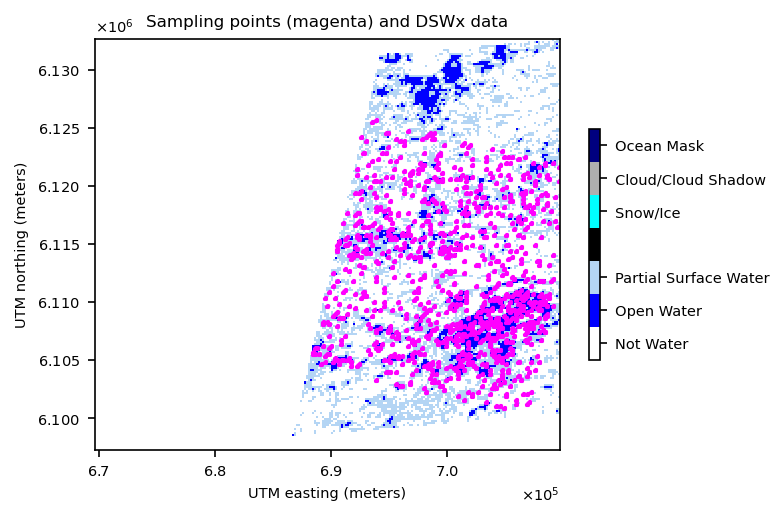

In [30]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
out = show(X_dswx_c,
     cmap=cmap,
     transform=p_dswx_c['transform'],
     interpolation='none',
     ax=ax,vmin=0,vmax=255)
df_samples.to_crs(p_dswx_c['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and DSWx data',fontsize=fontSizeTitle)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)

im_dswx = out.get_images()[0]

bounds =  [0, 1, 2, 3, 251, 252, 253, 254]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar=fig.colorbar(im_dswx, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 251.5, 252.5, 253.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Snow/Ice','Cloud/Cloud Shadow', 'Ocean Mask'],fontsize=fontSize)   
# cbar=fig.colorbar(im_dswx,ax=ax,shrink=0.4,ticks=[0.5, 1.5, 2.5,5.5,8.5, 9.5])
# cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Reserved','Snow/Ice','Cloud/Cloud Shadow'],fontsize=fontSize)   
# cbar.ax.set_ylim(0,10);

ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize)

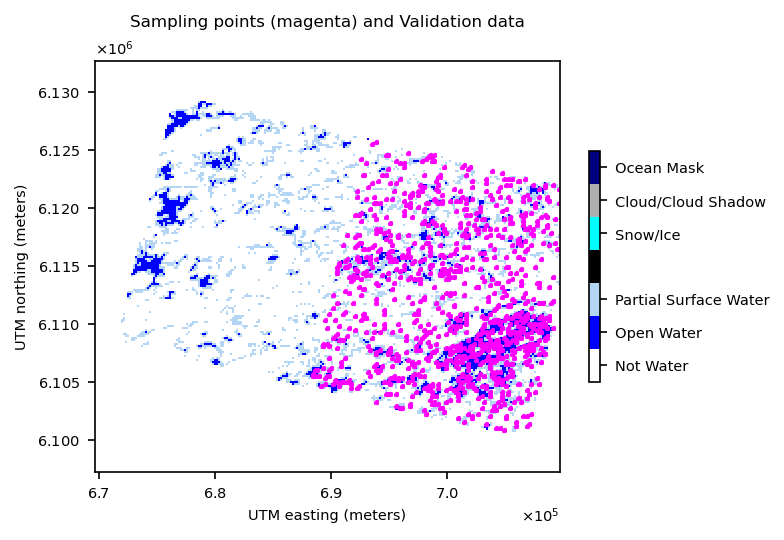

In [31]:
fontSize=7
fontSizeTitle=8
fig, ax = plt.subplots(dpi=150,figsize=(5,5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
out = show(X_val_r,cmap=cmap,transform=p_dswx_c['transform'],interpolation='none',ax=ax,vmin=0,vmax=255)
df_samples.to_crs(p_dswx_c['crs']).boundary.plot(ax=ax, color='magenta',alpha=1)
ax.set_title('Sampling points (magenta) and Validation data',fontsize=fontSizeTitle)
ax.ticklabel_format(axis='both', style='scientific',scilimits=(0,0),useOffset=False,useMathText=True)
plt.xlabel('UTM easting (meters)',fontsize=fontSize)
plt.ylabel('UTM northing (meters)',fontsize=fontSize)

im_dswx = out.get_images()[0]

bounds =  [0, 1, 2, 3, 251, 252, 253, 254]
norm = colors.BoundaryNorm(bounds, cmap.N)
cbar=fig.colorbar(im_dswx, ax=ax, shrink=0.4, boundaries=bounds, cmap=cmap, ticks=[0.5, 1.5, 2.5, 251.5, 252.5, 253.5])
cbar.set_ticklabels(['Not Water', 'Open Water','Partial Surface Water','Snow/Ice','Cloud/Cloud Shadow', 'Ocean Mask'],fontsize=fontSize)   

ax.yaxis.get_offset_text().set_fontsize(fontSize)
ax.xaxis.get_offset_text().set_fontsize(fontSize)
plt.yticks(fontsize=fontSize)
plt.xticks(fontsize=fontSize);

In [32]:
class_dict = {0: 'Not_Water',
              1: 'Open_Surface_Water', 
              2: 'Partial_Surface_Water'}
Target_Names=['Not_Water','Open_Surface_Water','Partial_Surface_Water']

y_val = np.array([[label for ind in stratified_selection[random_sample] for label in validation_hls_pixels[ind]]
                  for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                 ])
y_dswx = np.array([[label for ind in stratified_selection[random_sample] for label in dswx_hls_pixels[ind]]
                   for random_sample in range(NUMBER_OF_RANDOM_SAMPLES)
                  ])

In [33]:
def get_acc_per_class(y_val, y_dswx):
    acc_per_class = {}
    for c in [0, 1, 2]:
        y_val_temp = y_val.copy()
        y_dswx_temp = y_dswx.copy()

        y_val_temp[y_val_temp != c] = 255
        y_dswx_temp[y_dswx_temp != c] = 255

        acc_per_class[f'acc_per_class.{class_dict[c]}'] = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return acc_per_class

def get_binary_water_acc(y_val, y_dswx):
    
    y_val_temp = y_val.copy()
    y_dswx_temp = y_dswx.copy()

    y_val_temp[~np.isin(y_val_temp, [1, 2])] = 255
    y_val_temp[np.isin(y_val_temp, [1, 2])] = 1

    y_dswx_temp[~np.isin(y_dswx_temp, [1, 2])] = 255
    y_dswx_temp[np.isin(y_dswx_temp, [1, 2])] = 1

    binary_water_acc = (y_val_temp == y_dswx_temp).sum() / y_dswx.size
    return binary_water_acc

def get_prec_recall_score(y_val, y_dswx):

    # if no samples, we will assume perfect classification
    prec, recall, f1, supp = sklearn.metrics.precision_recall_fscore_support(y_val, y_dswx, labels=[0, 1, 2], zero_division=1)
        
    recall_per_class = {class_dict[label]: recall[label] for label in [0, 1, 2]}
    prec_per_class = {class_dict[label]: prec[label] for label in [0, 1, 2]}
    f1_per_class = {class_dict[label]: f1[label] for label in [0, 1, 2]}
    supp_per_class = {class_dict[label]: int(supp[label]) for label in [0, 1, 2]}
    binary_water_acc = get_binary_water_acc(y_val, y_dswx)
    return {
            'precision': prec_per_class,
            'recall': recall_per_class,
            'f1_per_class': f1_per_class,
            'supp_per_class':supp_per_class,
            'binary_water_acc': binary_water_acc}

def get_confusion_matrix(y_val, y_dswx):
    y_dswx_str = pd.Series([class_dict[class_id] for class_id in y_dswx], name='OPERA_DSWx')
    y_val_str = pd.Series([class_dict[class_id] for class_id in y_val], name='OPERA_Validation')
    df_conf = pd.crosstab(y_val_str, y_dswx_str)
    df_conf_formatted = df_conf.astype(int)
    
    name = df_conf.index.name
    df_conf_formatted.rename(index={index: f'{index}_{name}' for index in df_conf.index}, inplace=True)
    col_name = df_conf.columns.name
    df_conf_formatted.rename(columns={col: f'{col}_{col_name}' for col in df_conf.columns}, inplace=True)
    return df_conf_formatted

def get_metrics_for_one_sample(y_val, y_dswx):
    total_acc=sklearn.metrics.accuracy_score(y_val, y_dswx)
    
    pr_dict = get_prec_recall_score(y_val, y_dswx)
    acc_per_class = get_acc_per_class(y_val, y_dswx)
    df_conf_formatted = get_confusion_matrix(y_val, y_dswx)

    return {'total_accuracy': total_acc, 
            'confusion_matrix': df_conf_formatted.to_dict(),
            **pr_dict, 
            **acc_per_class}

In [34]:
data_temp = [(y_val[k], y_dswx[k]) for k in range(NUMBER_OF_RANDOM_SAMPLES)]
metric_data = list(starmap(get_metrics_for_one_sample, tqdm(data_temp)))

df_all_samples = pd.DataFrame(json_normalize(metric_data))
df_all_samples.head()

100%|██████████| 100/100 [00:00<00:00, 128.30it/s]


,total_accuracy,binary_water_acc,acc_per_class.Not_Water,acc_per_class.Open_Surface_Water,acc_per_class.Partial_Surface_Water,confusion_matrix.Not_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,confusion_matrix.Not_Water_OPERA_DSWx.Partial_Surface_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Not_Water_OPERA_Validation,confusion_matrix.Open_Surface_Water_OPERA_DSWx.Open_Surface_Water_OPERA_Validation,...,precision.Partial_Surface_Water,recall.Not_Water,recall.Open_Surface_Water,recall.Partial_Surface_Water,f1_per_class.Not_Water,f1_per_class.Open_Surface_Water,f1_per_class.Partial_Surface_Water,supp_per_class.Not_Water,supp_per_class.Open_Surface_Water,supp_per_class.Partial_Surface_Water
0,0.888224,0.927146,0.927146,0.960080,0.889222,266,1,4,0,317,...,0.785166,0.796407,0.949102,0.919162,0.879339,0.940653,0.846897,334,334,334
1,0.899202,0.932136,0.932136,0.966068,0.900200,269,1,2,0,317,...,0.795455,0.805389,0.949102,0.943114,0.887789,0.949102,0.863014,334,334,334
2,0.888224,0.931138,0.931138,0.955090,0.890220,269,2,2,0,314,...,0.787179,0.805389,0.940120,0.919162,0.886326,0.933135,0.848066,334,334,334
3,0.892216,0.916168,0.916168,0.976048,0.892216,256,0,6,0,328,...,0.786802,0.766467,0.982036,0.928144,0.859060,0.964706,0.851648,334,334,334
4,0.882236,0.918164,0.918164,0.963074,0.883234,256,1,3,0,320,...,0.771930,0.766467,0.958084,0.922156,0.861953,0.945347,0.840382,334,334,334


In [35]:
df_sample_stats = df_all_samples.aggregate(['mean', 'std'])

# includes new column with `*.std` and `*.mean`
temp_data = df_sample_stats.to_dict()
df_sample_stats = pd.json_normalize(temp_data)
# df_sample_stats['dswx_id'] = DSWx_ID
# df_sample_stats['planet_id'] = PLANET_ID
# df_sample_stats
stat_records = df_sample_stats.to_dict('records')[0]

In [36]:
mu_osw = stat_records['acc_per_class.Open_Surface_Water.mean']
sigma_osw = stat_records['acc_per_class.Open_Surface_Water.std']
open_surface_water_req = (mu_osw > .8 )
print('mu_osw:', mu_osw)
print('sigma_osw:', sigma_osw)
print('mu_osw - sigma_osw: ', mu_osw - sigma_osw)
open_surface_water_req

mu_osw: 0.966117764471058
sigma_osw: 0.0052203442536510975
mu_osw - sigma_osw:  0.9608974202174069


True

In [37]:
mu_psw = stat_records['acc_per_class.Partial_Surface_Water.mean']
sigma_psw = stat_records['acc_per_class.Partial_Surface_Water.std']
partial_surface_water_req = (mu_psw > .7 )
print('mu_psw:', mu_psw)
print('sigma_psw:', sigma_psw)
print('mu_psw - sigma_psw: ', mu_psw)
partial_surface_water_req

mu_psw: 0.8925748502994013
sigma_psw: 0.00866856228107504
mu_psw - sigma_psw:  0.8925748502994013


True

In [38]:
stats_data = df_sample_stats.to_dict('records')[0]
bw_mu = stats_data['binary_water_acc.mean']
bw_std = stats_data['binary_water_acc.std']

In [39]:
psw_str = f'{partial_surface_water_req} ({mu_psw:1.2f})'
osw_str = f'{open_surface_water_req} ({mu_osw:1.2f})'
df_requirement = pd.DataFrame([{'Class': 'PSW',
                                'OPERA Req.': partial_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_psw * 100:1.2f} ({sigma_psw * 100:1.2f})'},
                               {'Class': 'OSW',
                                'OPERA Req.': open_surface_water_req,
                                'Accuracy ($\%$)': f'{mu_osw * 100:1.2f} ({sigma_osw * 100:1.2f})'},
                               {'Class': 'Binary Water',
                                'OPERA Req.': 'N/A',
                                'Accuracy ($\%$)': f'{bw_mu * 100:1.2f} ({bw_std * 100:1.2f})'}
                              ])

def labeler(val):
    if val:
        if val != 'N/A':
            return 'Passed'
        else:
            return val
    return 'Not Passed'

df_requirement['OPERA Req.'] = df_requirement['OPERA Req.'].map(labeler)
df_requirement

,Class,OPERA Req.,Accuracy ($\%$)
0,PSW,Passed,89.26 (0.87)
1,OSW,Passed,96.61 (0.52)
2,Binary Water,N/A,92.46 (0.71)
